In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Step 0: Download the data from this [link](https://github.com/YorkNishi999/ganite_pytorch/tree/main/data) then upzip and put it (Twin_data.csv) in the `real_data` folder. See this [link](https://github.com/AMLab-Amsterdam/CEVAE/blob/master/datasets/TWINS/covar_desc.txt) for description / column dictionary of the data.

Step 1: data feature preprocessing

In [2]:
raw_data_path = 'Twin_data.csv'
df = pd.read_csv(raw_data_path)
df.columns = df.columns.str.strip("'").str.strip("’")

binary_cols = ['anemia', 'cardiac', 'lung', 'diabetes', 'herpes', 'hydra',
       'hemo', 'chyper', 'phyper', 'eclamp', 'incervix', 'pre4000', 'preterm',
       'renal', 'rh', 'uterine', 'othermr', 
       'gestat', 'dmage', 'dmeduc', 'dmar', 'nprevist', 'adequacy']
num_cols = ['dtotord', 'cigar', 'drink', 'wtgain']
cat_cols = ['pldel', 'resstatb', 'mpcb']
outcome_cols = ['outcome(t=0)', 'outcome(t=1)']
# fill missingness (value 8) with mode
for col in binary_cols:
    mode = df[col].mode()[0]
    df[col] = df[col].replace(8, mode)
    df[col] = df[col].apply(lambda x: 1 if x == 1 else 0) # yes: 1, no: 0
# OHE for categorical variables
ohe_cols = []
for col in cat_cols:
    dummies = pd.get_dummies(df[col], prefix=col, drop_first=True).astype(int)
    df = pd.concat([df, dummies], axis=1)
    df.drop(col, axis=1, inplace=True)
    ohe_cols += list(dummies.columns)

all_covariate_cols = binary_cols + num_cols + ohe_cols
print(all_covariate_cols)
print(f'Total number of covariates: {len(all_covariate_cols)}')
df[outcome_cols + binary_cols + num_cols + ohe_cols].sample(5)


['anemia', 'cardiac', 'lung', 'diabetes', 'herpes', 'hydra', 'hemo', 'chyper', 'phyper', 'eclamp', 'incervix', 'pre4000', 'preterm', 'renal', 'rh', 'uterine', 'othermr', 'gestat', 'dmage', 'dmeduc', 'dmar', 'nprevist', 'adequacy', 'dtotord', 'cigar', 'drink', 'wtgain', 'pldel_2', 'pldel_3', 'pldel_4', 'pldel_5', 'resstatb_2', 'resstatb_3', 'resstatb_4', 'mpcb_1', 'mpcb_2', 'mpcb_3', 'mpcb_4', 'mpcb_5', 'mpcb_6', 'mpcb_7', 'mpcb_8', 'mpcb_9']
Total number of covariates: 43


,outcome(t=0),outcome(t=1),anemia,cardiac,lung,diabetes,herpes,hydra,hemo,chyper,...,resstatb_4,mpcb_1,mpcb_2,mpcb_3,mpcb_4,mpcb_5,mpcb_6,mpcb_7,mpcb_8,mpcb_9
8566,9999,9999,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4613,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
7340,9999,9999,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
9296,9999,9999,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
9096,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0


Step 2: synthetic treatment assignment

In [3]:
# treatment assignment: according to SurvITE paper Appendix E.2: 
# w | x = Bernoulli( sigmoid(b1^T x + e) )
# where b1 is a vector of coefficients b1 ~ U(-0.1, 0.1)^43, 
# x is a vector of covariates, and e ~ N(0, 1^2)

sigmoid = lambda x: 1 / (1 + np.exp(-x))

seed = 522
np.random.seed(seed)
b1 = np.random.uniform(-0.1, 0.1, size=len(all_covariate_cols))
e = np.random.normal(0, 1, size=len(df))
df['W'] = ( np.random.binomial(1, sigmoid(b1 @ df[all_covariate_cols].T + e)) ).astype(int)
print(f'treatment rate = {df["W"].mean():.1%}')


treatment rate = 68.1%


Step 3: synthetic censoring time assignment

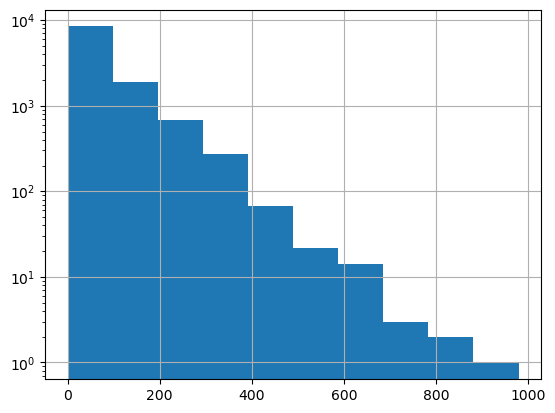

,outcome(t=0),outcome(t=1),C,W
3429,9999,6,1.163441e+02,1
2317,0,2,6.739884e-07,1
9902,9999,9999,7.259509e-06,0
6779,9999,9999,7.788189e+01,1
11353,9999,9999,6.641532e+00,1


In [4]:
# censoring assignment: according to SurvITE paper Appendix E.2:
# C ~ Exp(100 * sigmoid(b2^t x))
# b2 ~ N(0, 1^2)
seed = 522
np.random.seed(seed)
b2 = np.random.normal(0, 1, size=len(all_covariate_cols))
df['C'] = np.random.exponential(100 * sigmoid(b2 @ df[all_covariate_cols].T))
df['C'].hist()
plt.yscale('log')
plt.show()

df[outcome_cols + ['C', 'W']].sample(5)

Step 4: apply restricted mean survival time with h = 365, get necessary outcome label

censoring rate = 84.8%


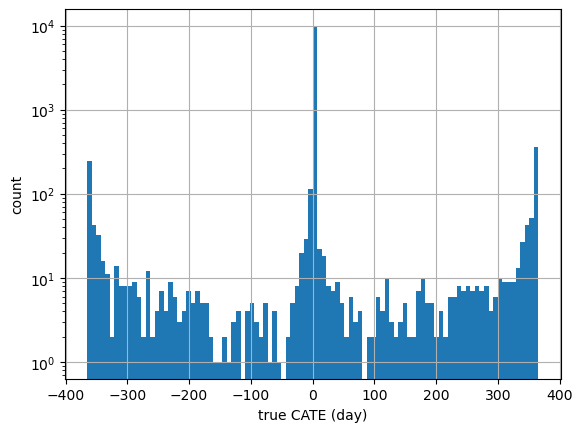

,observed_time,event,T0,T1,T,C,W,true_cate,anemia,cardiac,...,resstatb_4,mpcb_1,mpcb_2,mpcb_3,mpcb_4,mpcb_5,mpcb_6,mpcb_7,mpcb_8,mpcb_9
2510,7.973772,0,365,365,365,7.973772,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3430,65.098081,0,365,365,365,65.098081,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5411,69.973300,0,365,365,365,69.973300,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
844,7.477267,0,365,365,365,7.477267,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5109,3.024949,0,365,365,365,3.024949,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [5]:
h = 365
df['T0'] = df['outcome(t=0)']
df['T1'] = df['outcome(t=1)']
potential_outcome_cols = ['T0', 'T1']
for col in potential_outcome_cols:
    df[col] = df[col].apply(lambda x: min(x, h))

# get the event time according to the treatment assignment
df['T'] = np.where(df['W'] == 1, df['T1'], df['T0'])

# calculate the true CATE as the difference between the event time under treatment and control
df['true_cate'] = df['T1'] - df['T0']

# get the observed time and event indicator according to the censoring assignment
df['observed_time'] = np.minimum(df['T'], df['C'])
df['event'] = np.where(df['T'] <= df['C'], 1, 0)
print(f'censoring rate = {1 - df["event"].mean():.1%}')

df.true_cate.hist(bins=100)
plt.yscale('log')
plt.xlabel('true CATE (day)')
plt.ylabel('count')
plt.show()

df[['observed_time', 'event'] +['T0', 'T1'] + ['T', 'C', 'W', 'true_cate'] + binary_cols + num_cols + ohe_cols].to_csv('twin.csv', index=False)
df[['observed_time', 'event'] +['T0', 'T1'] + ['T', 'C', 'W', 'true_cate'] + binary_cols + num_cols + ohe_cols].sample(5)


In [6]:
# generate idx split
df_split = pd.DataFrame({'idx': range(len(df))})
for i in range(10):
    seed = 522 + i
    np.random.seed(seed)
    df_split[f'random_idx{i}'] = np.random.permutation(df_split['idx'] )
df_split.to_csv('idx_split_twin.csv', index=False)
df_split.head()

,idx,random_idx0,random_idx1,random_idx2,random_idx3,random_idx4,random_idx5,random_idx6,random_idx7,random_idx8,random_idx9
0,0,4673,8193,2015,1620,11124,2792,2763,3687,4907,9965
1,1,8847,4943,7700,4045,5430,5809,2248,6564,10370,386
2,2,5554,1711,1268,1411,11188,10742,6328,1891,1937,9248
3,3,9208,2687,11191,2758,8578,10274,10448,2396,5476,4819
4,4,337,9283,9089,878,3289,3300,9654,3714,7741,2289
